# 《猫和老鼠》目标识别
- 目的：检测《猫和老鼠》动画片中的猫Tom、老鼠Jerry及狗Speike

## 导入相关库

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import cv2
import imageio

#目标检测相关库
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util

D:\AI\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\AI\Jupyter_Dir\models\research\object_detection\utils\visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\AI\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\AI\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\AI\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_n

## 准备工作

#### 编译 TensorFlow models

- 下载好protoc，在models/research目录下执行
```
protoc object_detection/protos/*.proto --python_out=.
```
- 安装slim,在models/research目录下执行
```
python slim/setup.py install
```

#### 下载faster_rcnn模型
- 借助[faster_rcnn_inception_v2_coco](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)生成我们自己目标检测模型
- 我使用的版本是faster_rcnn_inception_v2_coco_2018_01_28及对应配置文件faster_rcnn_inception_v2_coco.config

#### 处理数据
- 下载动画片，从中截取图片，分成训练集和测试集
- 使用[Label Image](https://github.com/tzutalin/labelImg)打上标签
- 生成TFRecords文件

#### 配置
- 使用1表Tom；2表示Jerry；3表示Speike
```
def class_text_to_int(row_label):
    if row_label == 'Tom':
        return 1
    elif row_label == 'Jerry':
        return 2
    elif row_label == 'Speike':
        return 3
    else:
        None
```

- object-detection.pbtxt文件配置内容如下

```
item {
  id: 1
  name: 'Tom'
}

item {
  id: 2
  name: 'Jerry'
}

item {
  id: 3
  name: 'Speike'
}
```

- faster_rcnn_inception_v2_coco.config中主要修改如下：
 
 
 ```
 num_classes: 3
 
 train_input_reader: {
  tf_record_input_reader {
    input_path: "data/train.record"
  }
  label_map_path: "data/object-detection.pbtxt"
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "data/test.record"
  }
  label_map_path: "training/object-detection.pbtxt"
  shuffle: false
  num_readers: 1
}

```

#### 训练

python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_coco.config

#### 生成模型

python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path training/faster_rcnn_inception_v2_coco.config \
    --trained_checkpoint_prefix training/model.ckpt-1900 \
    --output_directory tom_and_jerry_raccoon_inference_graph

## 加载模型

#### detection_graph

In [2]:
PATH_TO_FROZEN_GRAPH = 'tom_and_jerry_raccoon_inference_graph/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

#### object-detection.pbtxt

In [3]:
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 目标检测

- 将图像数据转为numpy格式

In [4]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

- 加载测试图片：22张图

In [5]:
PATH_TO_TEST_IMAGES_DIR = 'Tom_and_Jerry_Test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'Tom_and_Jerry_{}.jpg'.format(i)) for i in range(1, 23) ]
IMAGE_SIZE = (12, 8)

In [6]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

- 绿色框标注的是猫Tom，黄框标注的是老鼠Jerry，淡黄色框标注的是狗Speike

D:\AI\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


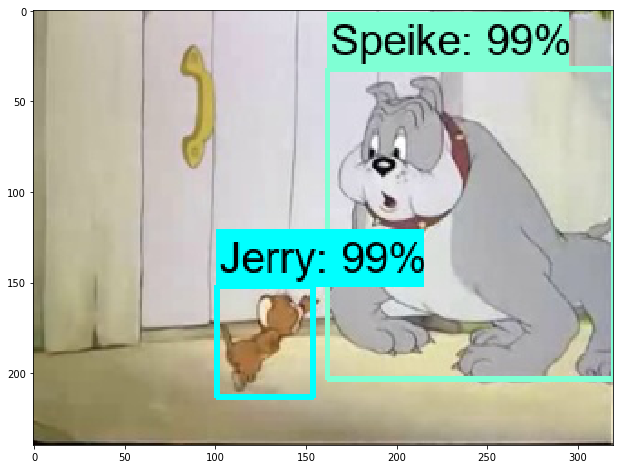

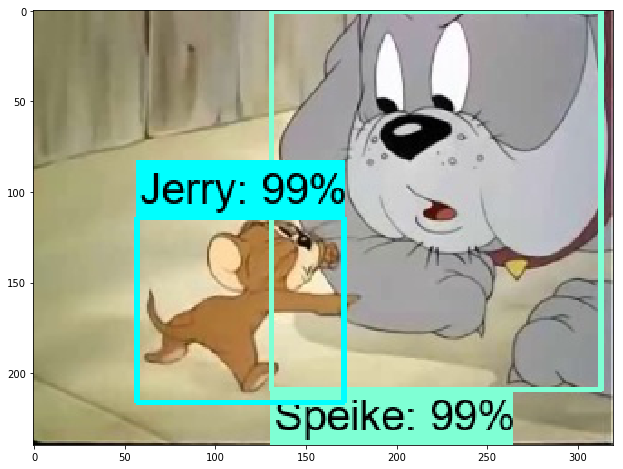

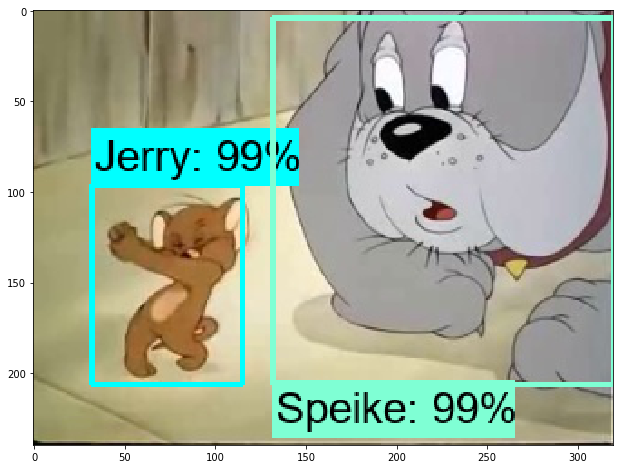

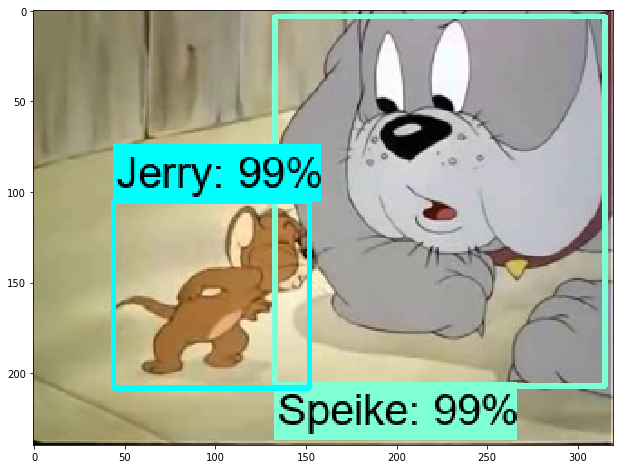

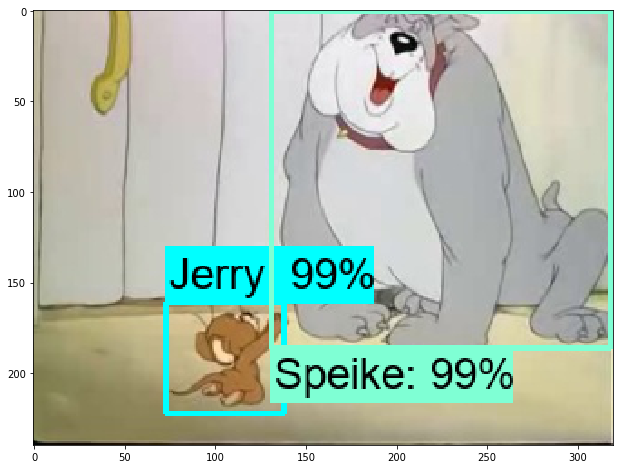

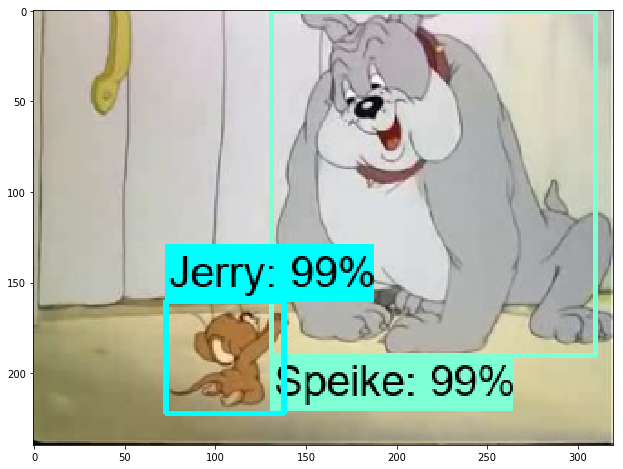

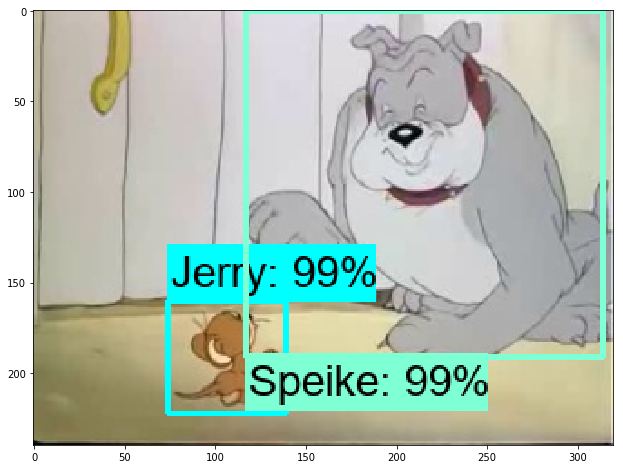

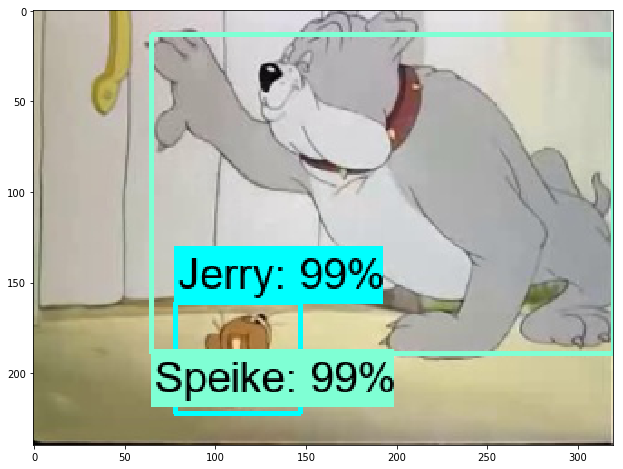

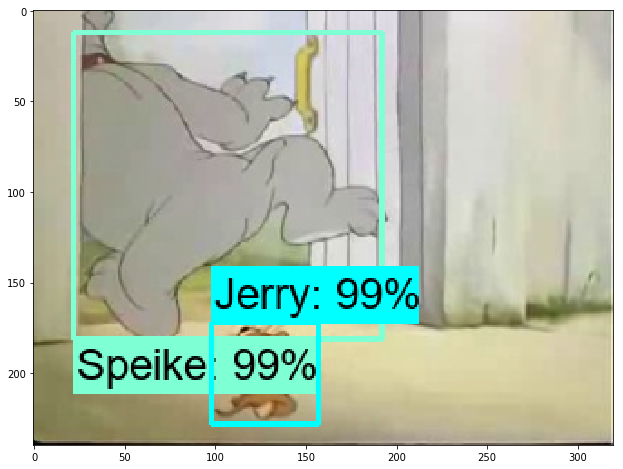

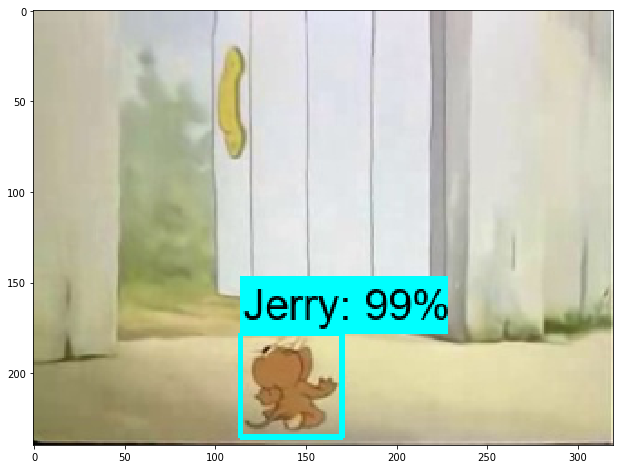

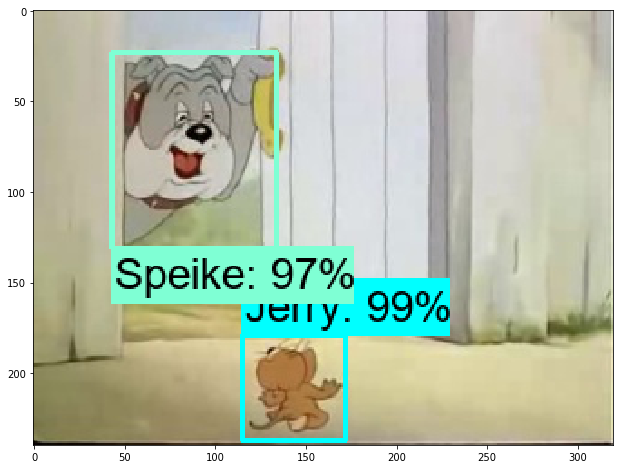

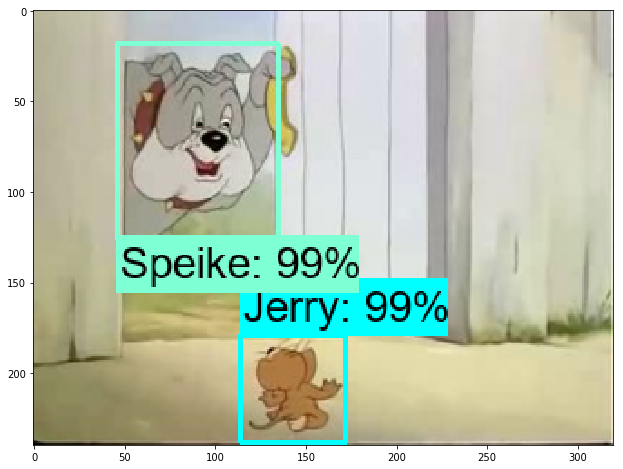

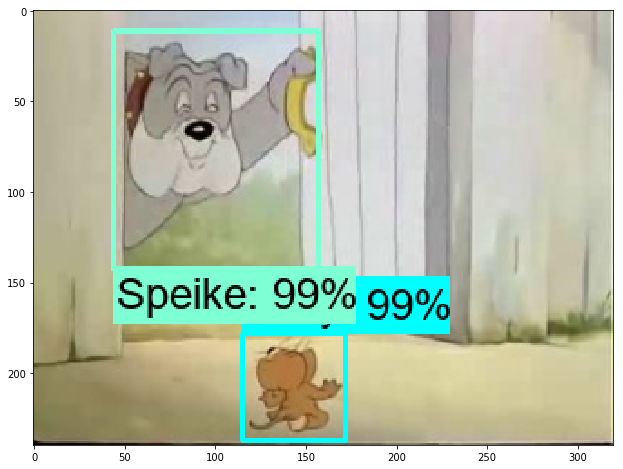

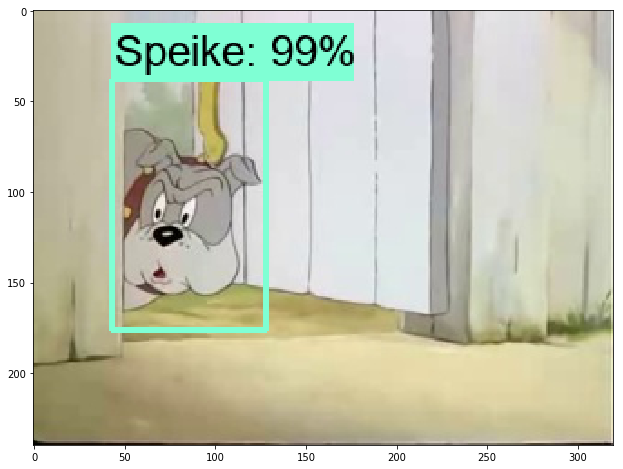

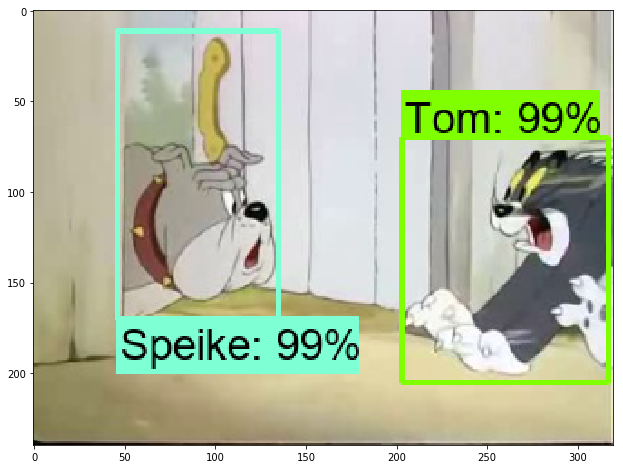

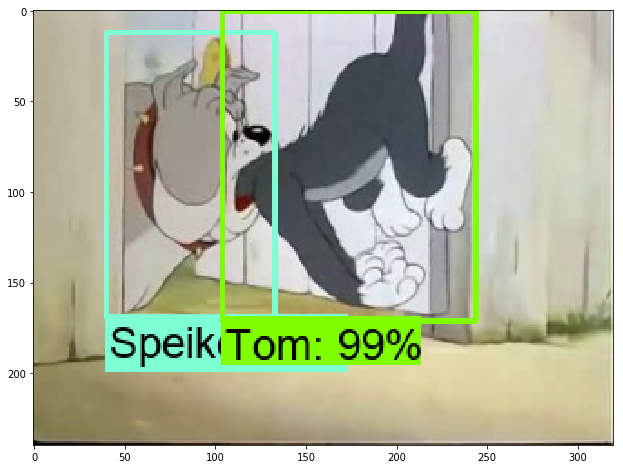

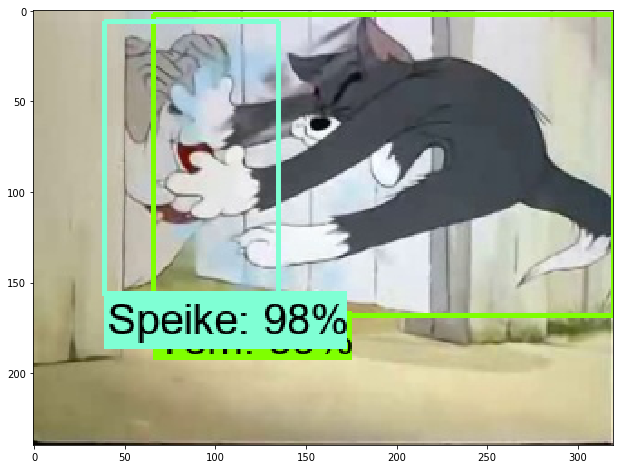

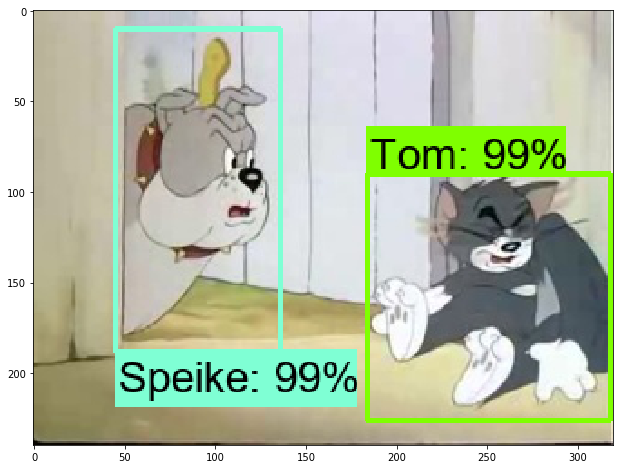

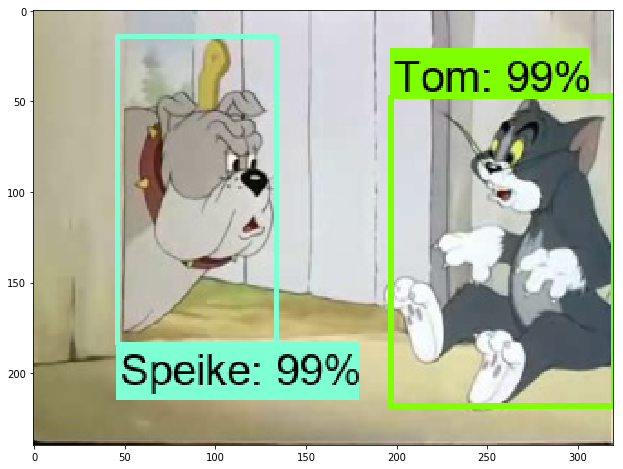

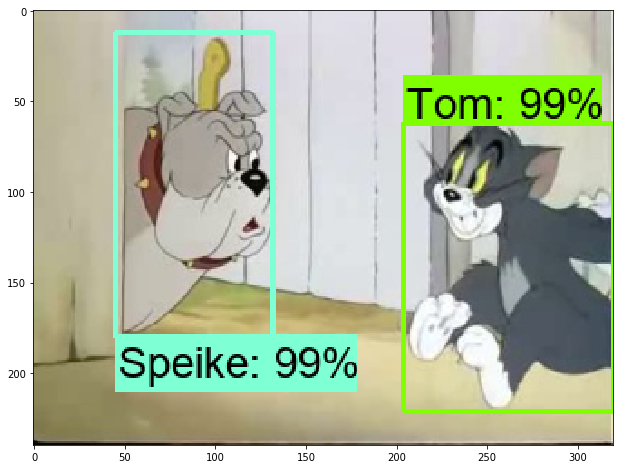

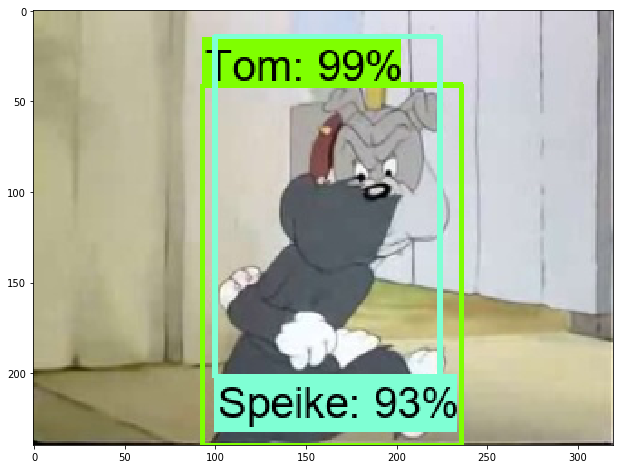

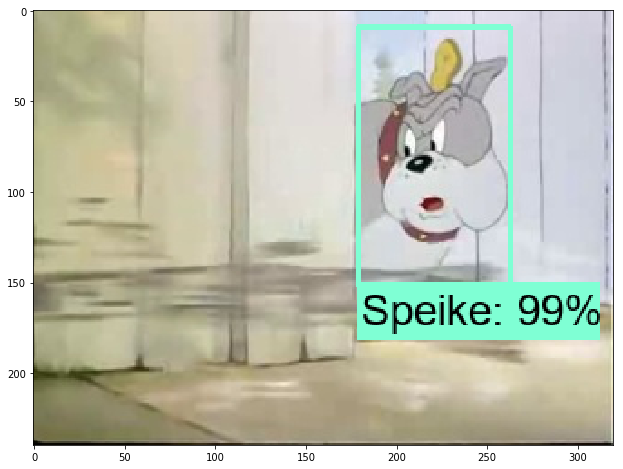

In [7]:
outfilename = "Tom_Jerry_Speike.gif"
frames = []
i = 1
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    cv2.imwrite("Tom_and_Jerry_Test/dst/{}.jpg".format(i), image_np)
    i += 1
    frames.append(image_np) 

- 将最终图片以gif格式显示出来

In [8]:
imageio.mimsave(outfilename, frames, 'GIF', duration=0.4)

![](../pic/Tom_Jerry_Speike.gif)